# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Classroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [1]:
!pip install opencv-python

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [3]:
class_names = ['mountain','street','glacier', 'buildings','sea','forest']

IMAGE_SIZE = (32,32)

In [4]:
#Pasar las clases de string a numeros del 1 al 5
class_names_label = {class_name:i for i ,class_name in enumerate(class_names)}
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [5]:
TRAIN_PATH = "seg_train"
TEST_PATH = "seg_test"

In [7]:
def read_data(path, im_size, class_names_label):
    X = []
    y = []

    for folder in os.listdir(path):
        label = class_names_label[folder]
        folder_path = os.path.join(path,folder)
        # Iterar sobre todo lo que haya en path
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path,file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, im_size)
            X.append(image)
            y.append(label)
    
    
    return np.array(X), np.array(y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE, class_names_label)
X_test, y_test = read_data(TEST_PATH, IMAGE_SIZE, class_names_label)

print(X_train.shape)
print(X_test.shape)

(14034, 32, 32, 3)
(3000, 32, 32, 3)


In [8]:
print(y_train.shape)
print(y_test.shape)

(14034,)
(3000,)


In [9]:
y_train

array([3, 3, 3, ..., 1, 1, 1])

In [10]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [11]:
y_train[0:10]

array([3, 1, 1, 4, 0, 2, 0, 0, 3, 1])

In [24]:
pd.DataFrame(y_train).value_counts()


0
0    2512
2    2404
1    2382
4    2274
5    2271
3    2191
Name: count, dtype: int64

In [25]:
X_train.max()

np.uint8(255)

buildings


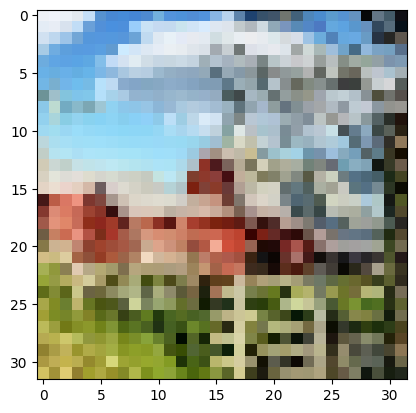

In [28]:
index = np.random.randint(X_train.shape[0])
print(class_names[y_train[index]])
plt.imshow(X_train[index]);

In [44]:
#Escalamos las imagenes
X_train_scal = X_train.astype("float32")/255
X_test_scal = X_test.astype("float32")/255

In [45]:
IMAGE_SIZE

(32, 32)

In [46]:
#Miramos si el shape es bueno
X_train_scal.shape

(14034, 32, 32, 3)

In [47]:
#Queremos hacer un modelo de una conv de 32 y otra de 64, ambas de (3,3) y con activacion relu, el imput_shape es (IMAGE_SIZE[0],IMAGE_SIZE[1],3)
#ambas con un maxpooling (2,2) y despues dos densas, la primera de 128 con activacion relu y la ultima de 6 osn softmax
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

model = keras.models.Sequential()

model.add(Conv2D(32, activation='relu', kernel_size=3, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, activation='relu', kernel_size=3))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(6, activation='softmax'))


c:\Users\Usuario\miniconda3\envs\data_analysis_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
# Primera capa conv
# 3 porque tenemos 3 capas RGB
# 32 porque hemos elegido en esta capa de convolución hacer 32 filtros
# 3*3 porque en cada filtro tenemos una matriz de 3*3 pixeles
# 32 bias
3*32*3*3 + 32

896

In [38]:
# Segunda capa conv
# 32 porque tenemos 32 filtros en el output de la anterior capa
# 64 porque hemos elegido en esta capa de convolución hacer 64 filtros
# 3*3 porque en cada filtro tenemos una matriz de 3*3 pixeles
# 64 bias
32*64*3*3 + 64

18496

In [39]:
2304*128 + 128

295040

In [49]:
#Hacemos el summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,702 (1.61 MB)

 Trainable params: 421,702 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
#Compilamos con:optimizer= 'adam', loss= "sparse_categorical_crossentropy", metrics=['accuracy']

model.compile(
    optimizer = "adam", 
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [51]:
#Fiteamos con un batch_size de 128, 10 epocas y validation split de 0.1
history = model.fit(
    X_train,
    y_train,
    batch_size = 128,
    epochs = 10,
    validation_split = 0.1,
    
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2629 - loss: 22.4024 - val_accuracy: 0.4993 - val_loss: 1.2882
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5618 - loss: 1.1296 - val_accuracy: 0.5940 - val_loss: 1.0600
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6498 - loss: 0.9040 - val_accuracy: 0.6218 - val_loss: 0.9980
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7040 - loss: 0.7778 - val_accuracy: 0.6368 - val_loss: 0.9995
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7385 - loss: 0.6866 - val_accuracy: 0.6695 - val_loss: 0.9946
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7917 - loss: 0.5680 - val_accuracy: 0.6410 - val_loss: 1.1312
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8225 - loss: 0.4820 - val_accuracy: 0.6603 - val_loss: 1.1130
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8497 - loss: 0.4030 - val_accuracy: 0.6474 - 

In [52]:
df_hist = pd.DataFrame(history.history)
df_hist

,accuracy,loss,val_accuracy,val_loss
0,0.363975,7.549201,0.499288,1.288208
1,0.579177,1.081164,0.594017,1.059955
2,0.658670,0.891403,0.621795,0.998027
3,0.704355,0.776668,0.636752,0.999542
4,0.738559,0.690611,0.669516,0.994582
5,0.784006,0.584123,0.641026,1.131216
6,0.817815,0.496588,0.660256,1.113036
7,0.840776,0.427739,0.647436,1.176522
8,0.869121,0.366907,0.645299,1.233487
9,0.888599,0.318557,0.638177,1.338892


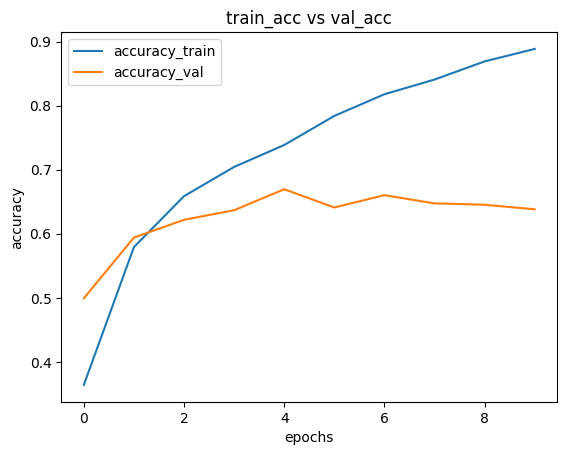

In [53]:
plt.figure()
plt.plot(df_hist['accuracy'], label="accuracy_train")
plt.plot(df_hist['val_accuracy'], label="accuracy_val")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

In [54]:
#Evaluamos el modelo con los datos escalados
results = model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6652 - loss: 1.2767


In [55]:
#Predicciones
predictions = model.predict(X_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [69]:
#buscar la prediccion buena
pred_labels = np.argmax(predictions, axis=1) 

In [70]:
pred_labels

array([3, 2, 3, ..., 0, 3, 1])

buildings


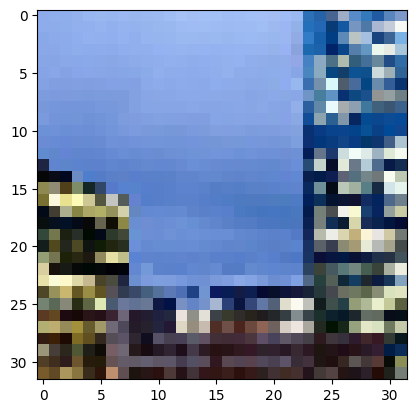

In [71]:
index=3
print(class_names[y_test[index]])
plt.imshow(X_test[index]);

In [72]:
#Sacamos el nombre de etiqueta de alguna prediccion
class_names[pred_labels[index]]

'glacier'

In [73]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [74]:
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [75]:
#Hacemos una matriz de confusion para ver que tal el modelo
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, pred_labels)
cm

array([[362,   3,  77,  29,  51,   3],
       [  9, 351,  26,  86,  15,  14],
       [114,   9, 332,  15,  82,   1],
       [ 20,  69,  19, 287,  28,  14],
       [ 82,   8, 109,  33, 272,   6],
       [  7,  65,   4,  42,   6, 350]])

In [76]:
#Hacemos un heatmap para verlo de coloritos la matriz
sns.heatmap(cm.corr())

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

# Bonus track

## Probad con diferentes modelos y diferentes tamaños de foto (cuidado con no pasaros de tamaño)